In [14]:
%load_ext autoreload
%autoreload 2

from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import arviz as az

import tensorflow.compat.v1 as tf1
import tensorflow.compat.v2 as tf

import tensorflow_probability as tfp
from tensorflow_probability.python.internal import prefer_static as ps
from tensorflow_probability.python.mcmc.internal import util as mcmc_util
from tensorflow_probability.python.mcmc.transformed_kernel import (
    make_transform_fn, make_transformed_log_prob)

tfd = tfp.distributions
tfb = tfp.bijectors

tf.enable_v2_behavior()

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from tensorflow_probability.python.experimental.mcmc.sample_sequential_monte_carlo import make_rwmh_kernel_fn
sample_sequential_monte_carlo_chain = tfp.experimental.mcmc.sample_sequential_monte_carlo

In [5]:
dfhogg = pd.DataFrame(
                np.array([[1, 201, 592, 61, 9, -0.84],
                          [2, 244, 401, 25, 4, 0.31],
                          [3, 47, 583, 38, 11, 0.64],
                          [4, 287, 402, 15, 7, -0.27],
                          [5, 203, 495, 21, 5, -0.33],
                          [6, 58, 173, 15, 9, 0.67],
                          [7, 210, 479, 27, 4, -0.02],
                          [8, 202, 504, 14, 4, -0.05],
                          [9, 198, 510, 30, 11, -0.84],
                          [10, 158, 416, 16, 7, -0.69],
                          [11, 165, 393, 14, 5, 0.30],
                          [12, 201, 442, 25, 5, -0.46],
                          [13, 157, 317, 52, 5, -0.03],
                          [14, 131, 311, 16, 6, 0.50],
                          [15, 166, 400, 34, 6, 0.73],
                          [16, 160, 337, 31, 5, -0.52],
                          [17, 186, 423, 42, 9, 0.90],
                          [18, 125, 334, 26, 8, 0.40],
                          [19, 218, 533, 16, 6, -0.78],
                          [20, 146, 344, 22, 5, -0.56]]),
                columns=['id','x','y','sigma_y','sigma_x','rho_xy'])

dfhogg['id'] = dfhogg['id'].apply(lambda x: 'p{}'.format(int(x)))
dfhogg.set_index('id', inplace=True)
dfhogg.head()

,x,y,sigma_y,sigma_x,rho_xy
id,,,,,
p1,201.0,592.0,61.0,9.0,-0.84
p2,244.0,401.0,25.0,4.0,0.31
p3,47.0,583.0,38.0,11.0,0.64
p4,287.0,402.0,15.0,7.0,-0.27
p5,203.0,495.0,21.0,5.0,-0.33


In [6]:
dfhoggs = ((dfhogg[['x', 'y']] - dfhogg[['x', 'y']].mean(0)) / 
           (2 * dfhogg[['x', 'y']].std(0)))
dfhoggs['sigma_x'] = dfhogg['sigma_x'] / ( 2 * dfhogg['x'].std())
dfhoggs['sigma_y'] = dfhogg['sigma_y'] / ( 2 * dfhogg['y'].std())

In [7]:
dtype = tf.float32
hyper_mean = tf.cast(0, dtype)
hyper_scale = tf.cast(10, dtype)
X = np.float32(dfhoggs['x'].values)
sigma = np.float32(dfhoggs['sigma_y'].values)
Y = np.float32(dfhoggs['y'].values)
Y = Y[None]

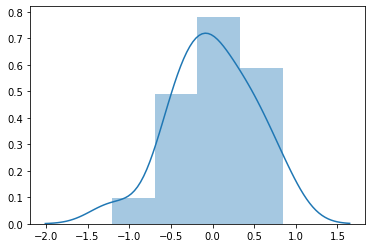

In [8]:
import seaborn as sns
sns.distplot(Y)

In [9]:
import pymc4 as pm
@pm.model()
def model():
    b0 = yield pm.Normal("b0", hyper_mean, hyper_scale)
    b1 = yield pm.Normal("b1", hyper_mean, hyper_scale)
    mu_out = yield pm.Normal("mu_out", hyper_mean, 10.)
    sigma_out = yield pm.HalfNormal("sigma_out", scale=tf.cast(1., dtype))
    weight = yield pm.Uniform("weight", low=tf.cast(0, dtype), high=.5)
    x = yield pm.Mixture("x", 
            tf.stack([
                tf.repeat(1-weight[..., tf.newaxis], 20, axis=-1),
                tf.repeat(weight[..., tf.newaxis], 20, axis=-1)
                ], 
                -1
            ),
            [
                pm.Normal.dist(loc=tf.squeeze(b0[..., tf.newaxis] + b1[..., tf.newaxis]*X),
                    scale=np.float32(np.squeeze(sigma))),
                pm.Normal.dist(loc=mu_out[..., tf.newaxis], 
                    scale=tf.squeeze(sigma+sigma_out[..., tf.newaxis]))
            ],
            observed=Y,
        )

In [10]:
final_state = pm.sample_smc(model())

In [11]:
var_name = ['__log_sigma_out', 'b0', 'b1', 'mu_out', 'weight']
posterior = {k:v for k, v in zip(var_name, final_state)}

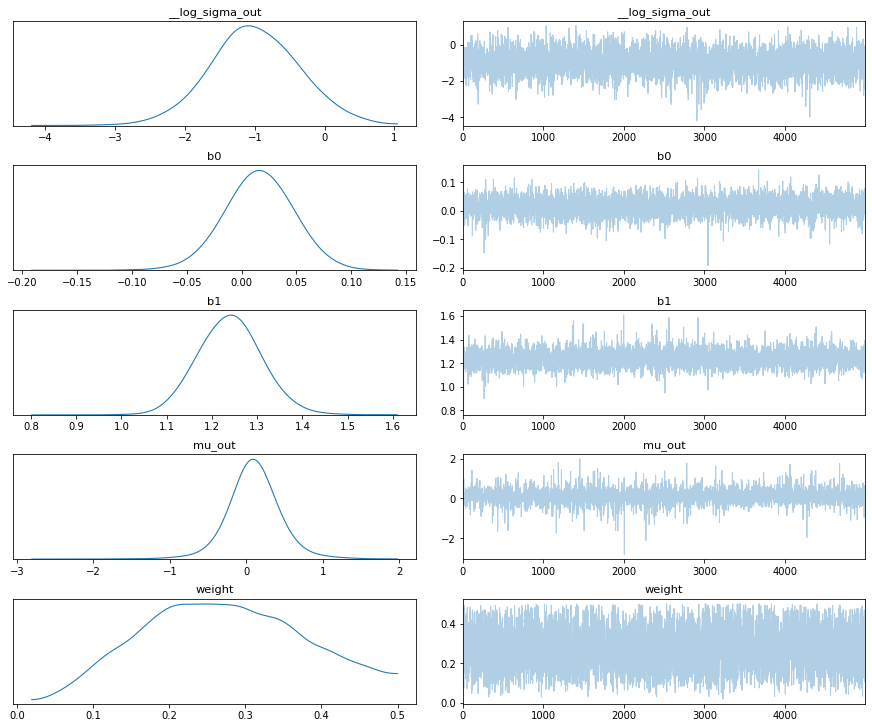

In [12]:
az_trace = az.from_dict(posterior=posterior)
az.plot_trace(az_trace);

In [13]:
%%time
trace = pm.sample(model(), progressbar=True, adaptation_kwargs={"target_accept_prob": 0.8}, initialize_smc=False)

100%|██████████| 1000/1000 [04:52<00:00,  3.70it/s]


CPU times: user 5min 35s, sys: 22.1 s, total: 5min 57s
Wall time: 4min 58s


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3e706560f0>,
      dtype=object)

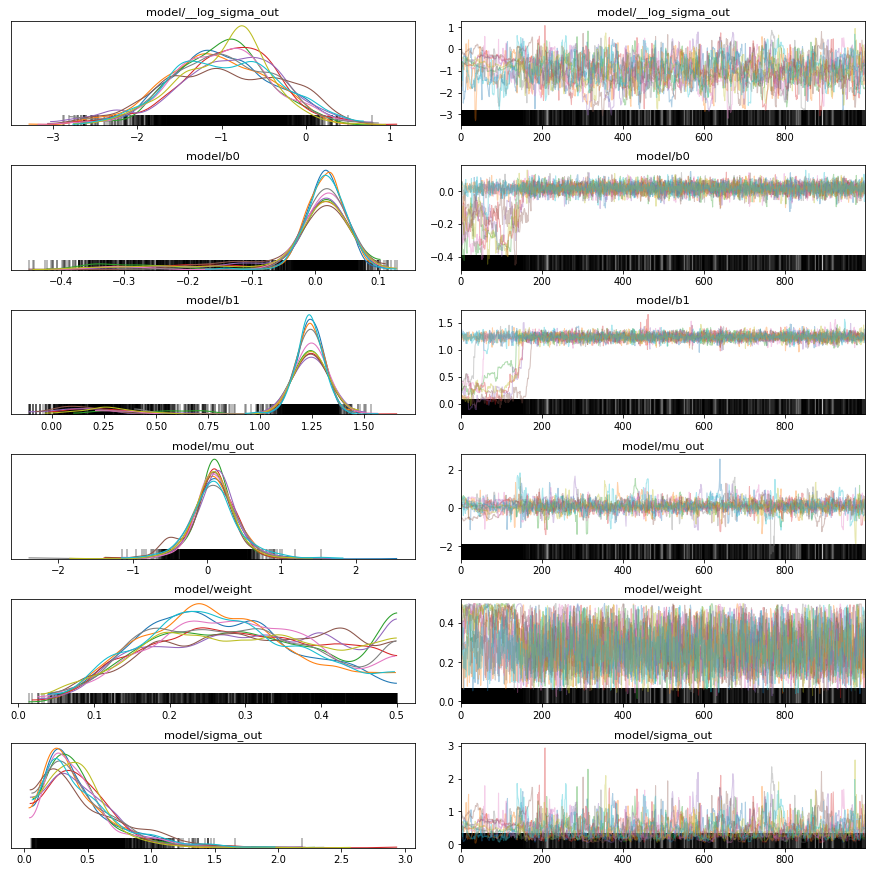

In [15]:
az.plot_trace(trace)

In [16]:
%%time
trace = pm.sample(model(), progressbar=True, adaptation_kwargs={"target_accept_prob": 0.8}, initialize_smc=True)

100%|██████████| 1000/1000 [02:24<00:00,  5.53it/s]

CPU times: user 2min 52s, sys: 9.33 s, total: 3min 1s
Wall time: 2min 41s


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3e48286e80>,
      dtype=object)

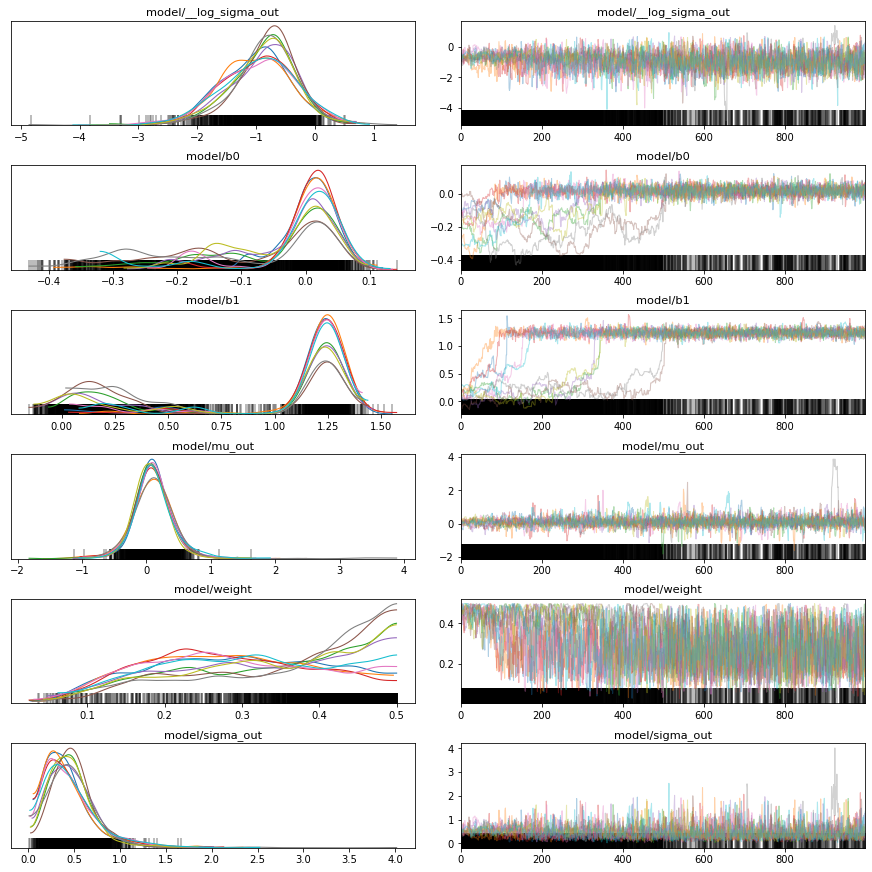

In [17]:
az.plot_trace(trace)

In [20]:
# TODO complete the whole tutorial